# Preparation
- Install the package


In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, Subset
import random
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import sys
import time
import shutil
import argparse

# Data Cleaning

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

# Load the MNIST dataset with the transformation
train_dataset = torchvision.datasets.EMNIST(
        root='./data', split='byclass', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.EMNIST(
        root='./data', split='byclass', train=False, download=True, transform=transform)

100%|██████████| 562M/562M [00:53<00:00, 10.5MB/s]


In [11]:
dataset_classes = train_dataset.classes
print(dataset_classes)
print(len(dataset_classes))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
62


In [29]:
# Only use uppercase letters and digits
train_indices = [i for i, (_, label) in enumerate(train_dataset) if label < 36]
train_subset = Subset(train_dataset, train_indices)

test_indices = [i for i, (_, label) in enumerate(test_dataset) if label < 36]
test_subset = Subset(test_dataset, test_indices)

In [31]:
from collections import Counter

# For training set
train_labels = [train_dataset[i][1] for i in train_indices]
train_class_counts = Counter(train_labels)

# For test set
test_labels = [test_dataset[i][1] for i in test_indices]
test_class_counts = Counter(test_labels)

In [32]:
# Print the counts
print("Training set class distribution:")
for class_idx in range(36):
    class_name = valid_classes[class_idx]
    count = train_class_counts[class_idx]
    print(f"Class {class_name}: {count} samples")

print("\nTest set class distribution:")
for class_idx in range(36):
    class_name = valid_classes[class_idx]
    count = test_class_counts[class_idx]
    print(f"Class {class_name}: {count} samples")

Training set class distribution:
Class 0: 34585 samples
Class 1: 38374 samples
Class 2: 34203 samples
Class 3: 35143 samples
Class 4: 33535 samples
Class 5: 31416 samples
Class 6: 34232 samples
Class 7: 35754 samples
Class 8: 33946 samples
Class 9: 33847 samples
Class A: 6407 samples
Class B: 3878 samples
Class C: 10094 samples
Class D: 4562 samples
Class E: 4934 samples
Class F: 9182 samples
Class G: 2517 samples
Class H: 3152 samples
Class I: 11946 samples
Class J: 3762 samples
Class K: 2468 samples
Class L: 5076 samples
Class M: 9002 samples
Class N: 8237 samples
Class O: 24983 samples
Class P: 8347 samples
Class Q: 2605 samples
Class R: 5073 samples
Class S: 20764 samples
Class T: 9820 samples
Class U: 12602 samples
Class V: 4637 samples
Class W: 4695 samples
Class X: 2771 samples
Class Y: 4743 samples
Class Z: 2701 samples

Test set class distribution:
Class 0: 5778 samples
Class 1: 6330 samples
Class 2: 5869 samples
Class 3: 5969 samples
Class 4: 5619 samples
Class 5: 5190 sample

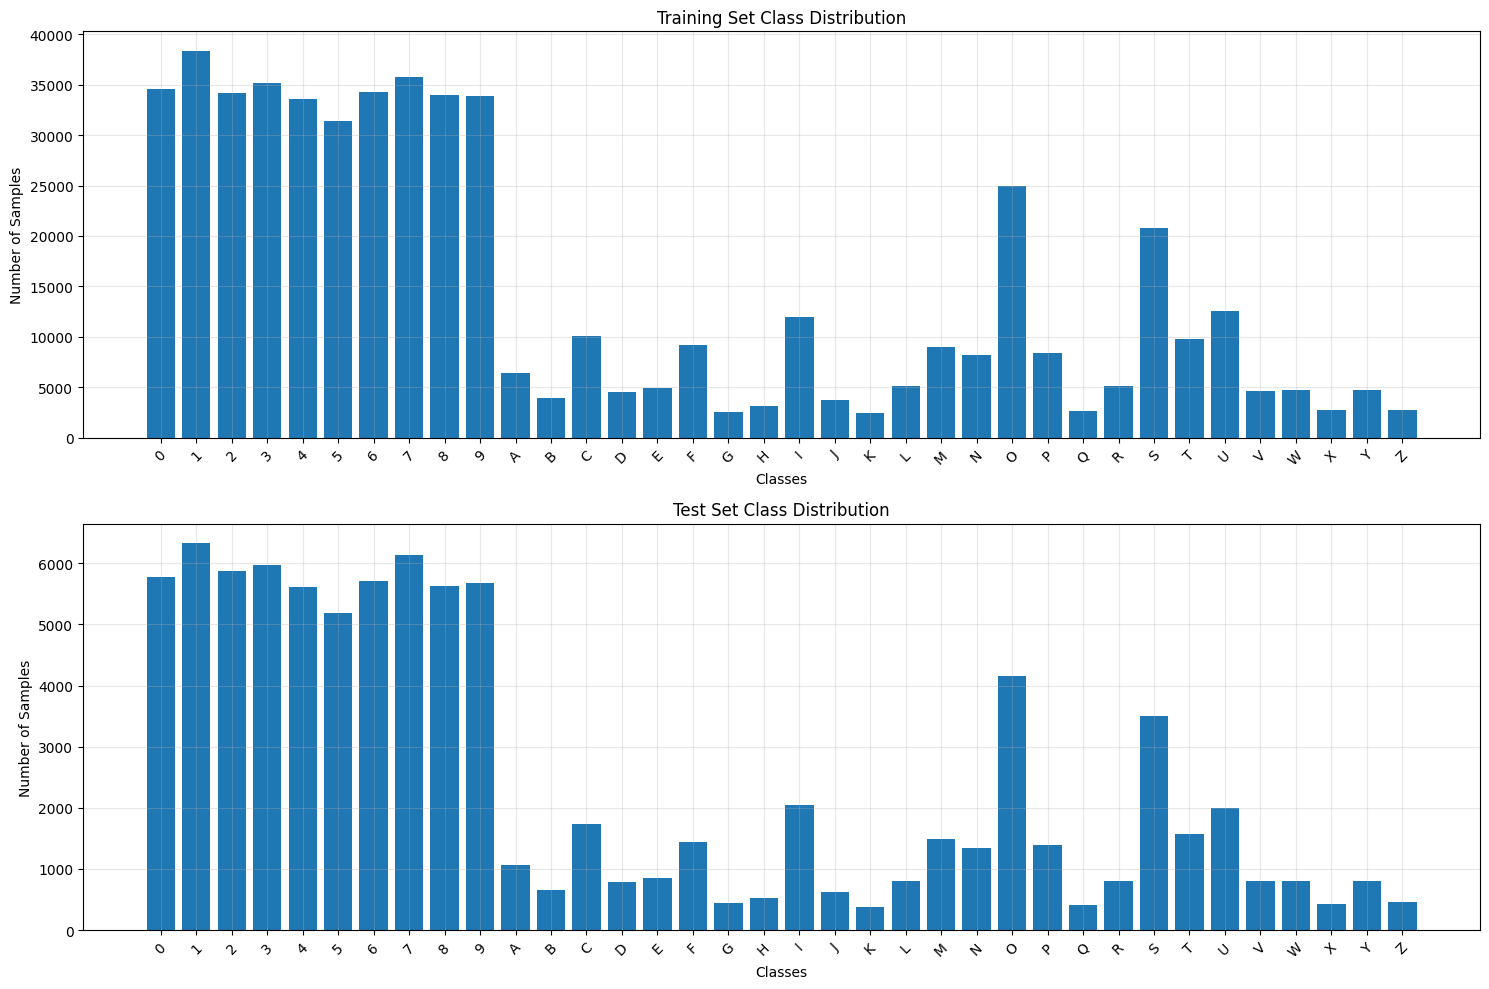

Total training samples: 533993
Total test samples: 89264


In [33]:
# Set figure size
plt.figure(figsize=(15, 10))

# Plot training set distribution
plt.subplot(2, 1, 1)
train_counts = [train_class_counts[i] for i in range(36)]
plt.bar(valid_classes, train_counts)
plt.title('Training Set Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Plot test set distribution
plt.subplot(2, 1, 2)
test_counts = [test_class_counts[i] for i in range(36)]
plt.bar(valid_classes, test_counts)
plt.title('Test Set Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

# You can also print the total numbers
print(f"Total training samples: {sum(train_counts)}")
print(f"Total test samples: {sum(test_counts)}")

Refer to the above, We discover that All classes are not balanced.

In [34]:
#Balanced all classes
def undersample_dataset(dataset, indices):
    labels = [dataset[i][1] for i in indices]
    class_counts = Counter(labels)
    min_count = min(class_counts.values())

    balanced_indices = []
    for class_idx in range(36):
        class_indices = [i for i, idx in enumerate(indices) if dataset[idx][1] == class_idx]
        # Randomly select min_count samples from each class
        balanced_indices.extend(np.random.choice(class_indices, min_count, replace=False))

    return Subset(dataset, [indices[i] for i in balanced_indices])

In [35]:
balanced_train_dataset = undersample_dataset(train_dataset, train_indices)
balanced_test_dataset = undersample_dataset(test_dataset, test_indices)

In [36]:
def check_balance(dataset):
    if isinstance(dataset, Subset):
        labels = [dataset.dataset[i][1] for i in dataset.indices]
    else:
        labels = [sample[1] for sample in dataset]
    class_counts = Counter(labels)
    return class_counts


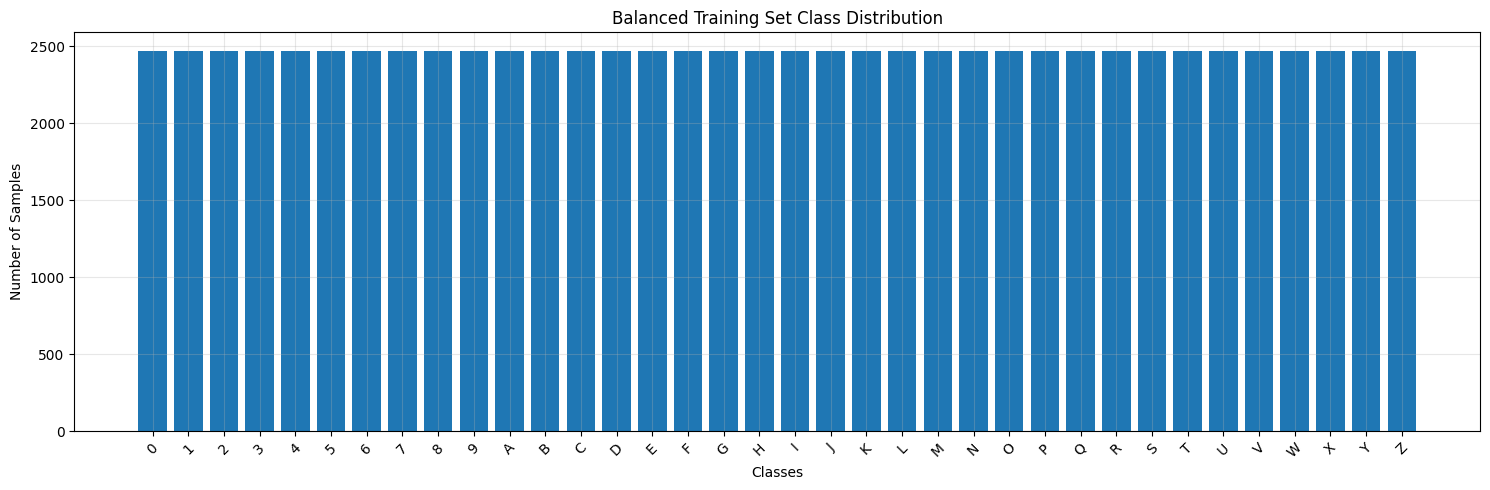

In [37]:
balanced_train_counts = check_balance(balanced_train_dataset)
plt.figure(figsize=(15, 5))
balanced_counts = [balanced_train_counts[i] for i in range(36)]
plt.bar(valid_classes, balanced_counts)
plt.title('Balanced Training Set Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [39]:
'''
# Custom transformation to add Salt-and-Pepper noise
class AddSaltPepperNoise:
    def __init__(self, salt_prob=0.01, pepper_prob=0.01):
        self.salt_prob = salt_prob    # Probability of salt noise (white pixels)
        self.pepper_prob = pepper_prob  # Probability of pepper noise (black pixels)

    def __call__(self, tensor):
        # Convert tensor to numpy for easier manipulation
        img = tensor.numpy()

        # Create a noise mask
        noise = np.random.random(img.shape)

        # Add salt noise (white pixels)
        img[noise < self.salt_prob] = 1.0

        # Add pepper noise (black pixels)
        img[noise > (1 - self.pepper_prob)] = 0.0

        return torch.from_numpy(img)

    def __repr__(self):
        return self.__class__.__name__ + '(salt_prob={0}, pepper_prob={1})'.format(self.salt_prob, self.pepper_prob)

# Define the augmentation pipeline with Salt-and-Pepper noise
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.1307,), (0.3081,)),  # Normalize
    transforms.RandomAffine(degrees=(-5,5), translate=(0.1, 0.1), scale=(0.9, 1.1), shear=5),  # Random affine
    transforms.RandomApply([transforms.ColorJitter(brightness=0.1, contrast=0.1)], p=0.3),
    transforms.RandomApply([AddSaltPepperNoise(salt_prob=0.01, pepper_prob=0.01)], p=0.3)  # Add Salt-and-Pepper noise
])


# Model Architecture

In [57]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, 1, padding=1)  # Added padding
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, 1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 3, 1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.4)

        # Calculate the correct input size for fc1
        self.fc1 = nn.Linear(256 * 7 * 7, 512)  # Size adjusted for padding
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 36)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.dropout1(x)
        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)

        x = self.fc2(x)
        x = F.relu(x)

        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

# Training

In [44]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.functional.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        if batch_idx % args.log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

    train_loss /= len(train_loader)
    accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss, accuracy

In [45]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += torch.nn.functional.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)\n')

    return test_loss, accuracy


In [72]:
# Train and Evaluate
def train_and_evaluate(args, model, device, train_loader, test_loader, optimizer, scheduler):
    test_losses = []
    test_accuracies = []
    train_losses = []
    train_accuracies = []

    best_test_loss = float('inf')
    best_test_accuracy = 0  # Changed from float('inf') to 0 since we want higher accuracy

    patience = 10
    no_improvement_count = 0

    # Create the model directory with the seed from args
    model_dir = f"EMNIST_Model_seed_{args.seed}"
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    for epoch in range(1, args.epochs + 1):
        train_loss, train_accuracy = train(args, model, device, train_loader, optimizer, epoch)
        test_loss, test_accuracy = test(model, device, test_loader)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        # Check if current test accuracy is better than the best so far
        if test_accuracy > best_test_accuracy:
            best_test_accuracy = test_accuracy
            no_improvement_count = 0
            if args.save_model and epoch > 4:
                model_filename = f"emnist_cnn_epoch:{epoch}_test-accuracy:{test_accuracy:.4f}_test-loss:{test_loss:.4f}.pt"
                model_path = os.path.join(model_dir, model_filename)
                try:
                    torch.save(model.state_dict(), model_path)
                    print(f"Model saved with new best test accuracy: {best_test_accuracy:.4f}% \n")
                except Exception as e:
                    print(f"Error saving model: {e}")
        else:
            no_improvement_count += 1

        if no_improvement_count >= patience:
            print(f"\nEarly stopping triggered after {epoch} epochs. No improvement in test accuracy for {patience} consecutive epochs.")
            break

        scheduler.step()

    return train_losses, train_accuracies, test_losses, test_accuracies

In [47]:
# Plot graphs
def plot_results(train_losses, train_accuracies, test_losses, test_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Train Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'o-', label='Train Loss')
    plt.plot(epochs, test_losses, 'o-', label='Test Loss')
    plt.title('Loss vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'o-', label='Train Accuracy')
    plt.plot(epochs, test_accuracies, 'o-', label='Test Accuracy')
    plt.title('Accuracy vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Main Function

In [61]:
# Define the augmentation pipeline with thinning and Gaussian noise
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.1307,), (0.3081,)),  # Normalize
    transforms.RandomAffine(degrees=(-5,5), translate=(0.2, 0.2), scale=(0.7, 1.3), shear=10),  # Random affine
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=1)], p=0.3),  # Gaussian blur
    transforms.RandomApply([transforms.ColorJitter(brightness=0.1, contrast=0.1)], p=0.3),
    transforms.RandomApply([AddGaussianNoise(mean=0., std=0.1)], p=0.2)  # Add Gaussian noise
])


In [66]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


In [71]:
# Create a configuration class instead of using argparse
class Config:
    def __init__(self):
        self.batch_size = 64
        self.test_batch_size = 1000
        self.epochs = 14
        self.lr = 1.0
        self.gamma = 0.7
        self.no_cuda = False
        self.seed = 1
        self.log_interval = 10  # Added for train function
        self.save_model = True  # Added for train_and_evaluate function

In [69]:
class TransformedSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, idx):
        x, y = self.subset[idx]
        if self.transform:
            if isinstance(x, torch.Tensor):  # If data is already a tensor
                # Apply only the augmentation transforms, skip ToTensor()
                for t in self.transform.transforms:
                    if not isinstance(t, transforms.ToTensor):
                        x = t(x)
            else:  # If data is not a tensor
                x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

In [73]:
def main():
    # Use Config instead of argument parser
    args = Config()

    use_cuda = not args.no_cuda and torch.cuda.is_available()
    torch.manual_seed(args.seed)
    device = torch.device("cuda" if use_cuda else "cpu")

    # Define batch size and other parameters
    train_kwargs = {'batch_size': args.batch_size}
    test_kwargs = {'batch_size': args.test_batch_size}

    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                      'pin_memory': True,
                      'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    # Data augmentation for training
    transform_train = transforms.Compose([
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.RandomAffine(degrees=(-5,5), translate=(0.1, 0.1), scale=(0.6, 1.3), shear=10),
        transforms.RandomApply([AddGaussianNoise(mean=0., std=0.1)], p=0.2),
    ])

    # Transform for testing
    transform_test = transforms.Compose([
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    # Create new datasets with transforms
    train_dataset_transformed = TransformedSubset(balanced_train_dataset, transform_train)
    test_dataset_transformed = TransformedSubset(balanced_test_dataset, transform_test)

    # Create data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset_transformed, **train_kwargs)
    test_loader = torch.utils.data.DataLoader(test_dataset_transformed, **test_kwargs)

    # Model and Optimizer Initialization
    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)
    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)

    # Train and Evaluate
    train_losses, train_accuracies, test_losses, test_accuracies = train_and_evaluate(
        args, model, device, train_loader, test_loader, optimizer, scheduler)

    # Plot Results
    plot_results(train_losses, train_accuracies, test_losses, test_accuracies)

    # Save the final model state if needed
    if args.save_model:
        final_model_path = os.path.join(f"EMNIST_Model_seed_{args.seed}", "final_model.pt")
        torch.save(model.state_dict(), final_model_path)
        print(f"Final model saved to {final_model_path}")

Train Epoch: 1 [0/88848 (0%)]	Loss: 3.570498
Train Epoch: 1 [640/88848 (1%)]	Loss: 3.593480
Train Epoch: 1 [1280/88848 (1%)]	Loss: 3.517809
Train Epoch: 1 [1920/88848 (2%)]	Loss: 3.544542
Train Epoch: 1 [2560/88848 (3%)]	Loss: 3.449605
Train Epoch: 1 [3200/88848 (4%)]	Loss: 3.450641
Train Epoch: 1 [3840/88848 (4%)]	Loss: 3.314617
Train Epoch: 1 [4480/88848 (5%)]	Loss: 3.210487
Train Epoch: 1 [5120/88848 (6%)]	Loss: 3.240982
Train Epoch: 1 [5760/88848 (6%)]	Loss: 3.261878
Train Epoch: 1 [6400/88848 (7%)]	Loss: 3.393838
Train Epoch: 1 [7040/88848 (8%)]	Loss: 2.923315
Train Epoch: 1 [7680/88848 (9%)]	Loss: 2.895454
Train Epoch: 1 [8320/88848 (9%)]	Loss: 3.177953
Train Epoch: 1 [8960/88848 (10%)]	Loss: 2.969947
Train Epoch: 1 [9600/88848 (11%)]	Loss: 2.888489
Train Epoch: 1 [10240/88848 (12%)]	Loss: 2.903891
Train Epoch: 1 [10880/88848 (12%)]	Loss: 2.645142
Train Epoch: 1 [11520/88848 (13%)]	Loss: 2.691997
Train Epoch: 1 [12160/88848 (14%)]	Loss: 2.768113
Train Epoch: 1 [12800/88848 (14%)]

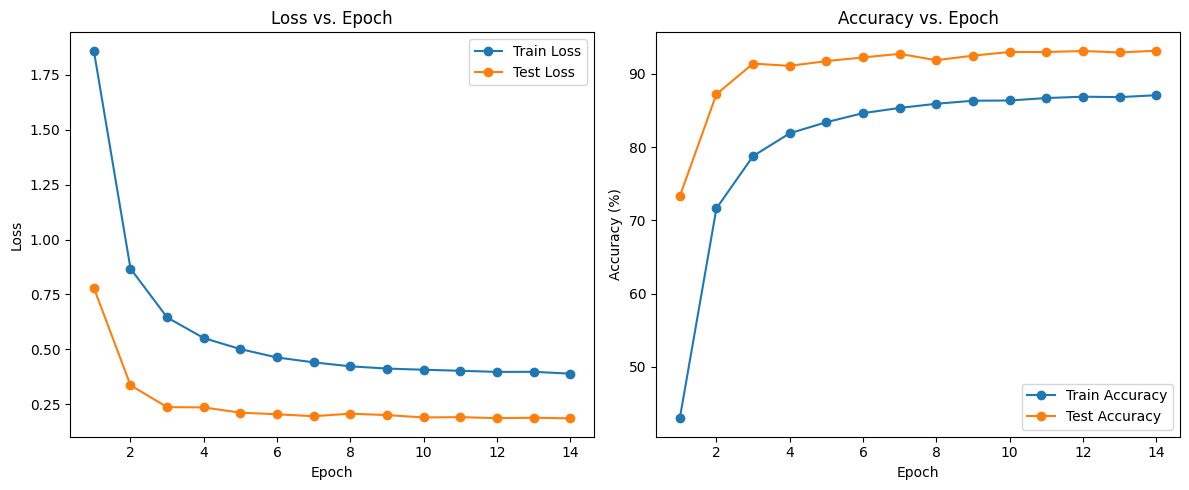

Final model saved to EMNIST_Model_seed_1/final_model.pt


In [74]:
if __name__ == '__main__':
    main()